In [21]:
import eikon as ek

import pandas as pd
import numpy as np
from tqdm import tqdm
import os

import utils

ek.set_app_key('89915a3b58874e1599870c6ecc45d6edd6344f8c')

In [22]:
ek.get_data(constituents_list[0],'TR.PriceClose')

(  Instrument  Price Close
 0      III.L       1676.5,
 None)

### Download Function
---

In [10]:
constituents_list = pd.read_excel(r'C:\Users\hugo.perezdealbeniz\Desktop\Ranking DIP European Equities\ReutersEikon\data_retrieval_eikon.xlsm',sheet_name='JL_data',skiprows=8)['Unnamed: 7'].dropna().tolist()

In [11]:
len(constituents_list)

1825

In [17]:
fields_list = [#'TR.TotalDebtToEV',
 #'TR.EV',
 #'TR.EVToSales',
 #'TR.NetDebtToEV',
 #'TR.PriceToSalesPerShare',
 #'TR.EVTOEBIT',
 #'TR.PE',
 #'TR.PriceToCFPerShare',
 #'TR.PriceToBVPerShare',
 #'TR.NetDebtToEBITDA',
 #'TR.TotalDebtToEBITDA',
 #'TR.EVTOEBITDA',
 #'TR.CompanyMarketCapitalization',
 #'TR.EVTOOperatingCashFlow',
 #'TR.PriceToTangBVPerShare',
 #'TR.HistPEG',
 'TR.DividendYield']

In [13]:
parameters = {'SDate':'2000-01-01','EDate':'2023-01-01','Frq':'M','Curn':'EUR'}

### Reconstruction
---

- concat all the dfs
- dropna
- drop duplicates
- pivot  
- should check len of individual dfs so faulty ones get get dropped (only if interferes with pivot)
- concated_df['Date'] = concated_df.Date.apply(lambda x: x[:10])
- pivoted_df = concated_df.pivot(index='Date',columns='Instrument',values='Price Close')
- to_csv()

In [14]:
def vertical_download(fields_list,constituents_list,parameters):
    
    os.chdir(r'C:\Users\hugo.perezdealbeniz\Desktop\Ranking DIP European Equities\ReutersEikon\data\mass_download_vertical')
    
    for field in fields_list:
        try:
            field_name = field.split('.')[-1]
            os.mkdir(field_name)
            os.mkdir(field_name+'/raw_data')
            fields = [field,field+'.date']
            print(f'Downloading {field_name}')

            fails = []
            dfs_list = []
            
            for instrument in tqdm(constituents_list):
                try:
                    df, err = ek.get_data(instrument, fields, parameters)
                    df.to_csv(f"{field_name}/raw_data/{instrument}.csv")
                    dfs_list.append(df)
                except Exception as x:
                    fails.append(instrument)
                    print(x)
            for instrument in tqdm(fails):
                try:
                    df, err = ek.get_data(instrument, fields, parameters)
                    df.to_csv(f"{field_name}/raw_data/{instrument}.csv")
                    dfs_list.append(df)
                except Exception as x:
                    print(f'Failed twice for {instrument}',x)

            concated_df = pd.concat(dfs_list)
            processed_df = concated_df.dropna().drop_duplicates()
            processed_df['Date'] = processed_df.Date.apply(lambda x: x[:10])
            pivoted_df = processed_df.pivot(index='Date',columns='Instrument',values=list(set(processed_df.columns)-set(['Date','Instrument']))[0])
            days_list = utils.create_dates_list('days',as_str=True)
            months_list = utils.create_dates_list('months',as_str=True)
            dates_dict = {}
            for i in days_list:
                dates_dict[i] = pd.NA
            dates_dict.update(pivoted_df.T.to_dict())
            complete_dates_df = pd.DataFrame(dates_dict).T.sort_index()
            filled_df = complete_dates_df.fillna(method='ffill',limit=7).loc[months_list]
            filled_df.to_csv(f'{field_name}/{field_name}.csv')
        except Exception as x:
            print(x)

In [ ]:
import time

In [23]:
#time.sleep(32272)

vertical_download(fields_list,constituents_list,parameters)

  7%|▋         | 119/1825 [06:42<1:26:37,  3.05s/it]2023-04-11 12:38:35,293 P[20888] [MainThread 5904] Backend error. 400 Bad Request
2023-04-11 12:38:35,294 P[20888] [MainThread 5904] HTTP request failed: EikonError-Backend error. 400 Bad Request
  7%|▋         | 120/1825 [07:01<3:35:32,  7.59s/it]

Error code 400 | Backend error. 400 Bad Request


2023-04-11 12:38:53,652 P[20888] [MainThread 5904] Backend error. 400 Bad Request
2023-04-11 12:38:53,654 P[20888] [MainThread 5904] HTTP request failed: EikonError-Backend error. 400 Bad Request
  7%|▋         | 121/1825 [07:19<5:07:13, 10.82s/it]

Error code 400 | Backend error. 400 Bad Request


 17%|█▋        | 307/1825 [39:43<3:16:24,  7.76s/it]


KeyboardInterrupt: 

In [33]:
dir_fp = r'C:\Users\hugo.perezdealbeniz\Desktop\Ranking DIP European Equities\ReutersEikon\data\mass_download_vertical'

CompanyMarketCapitalization
EV
EVTOEBIT
EVTOEBITDA
EVTOOperatingCashFlow
EVToSales
HistPEG
NetDebtToEBITDA
NetDebtToEV
NetDebtToEV_first_attempt
PE
PriceClose
PriceToBVPerShare
PriceToCFPerShare
PriceToSalesPerShare
PriceToTangBVPerShare
TotalDebtToEBITDA
TotalDebtToEV


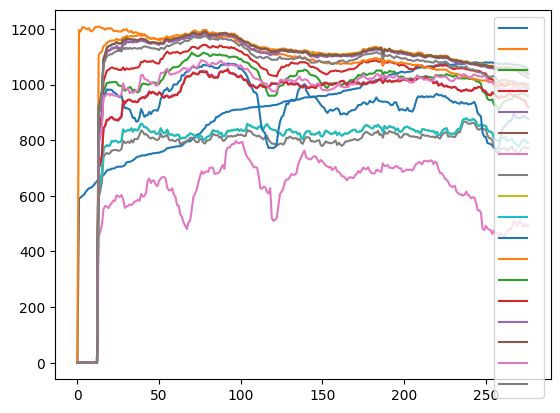

In [53]:
for index,i in enumerate(os.listdir(dir_fp)):
    if index > 20:# or i=='PriceToTangBVPerShare':
        continue
    print(i)
    df = pd.read_csv(dir_fp+f'/{i}/{i}.csv')
    df.notna().sum(axis=1).plot(legend=True)

In [50]:
#dir_fp = r'C:\Users\hugo.perezdealbeniz\Desktop\Ranking DIP European Equities\ReutersEikon\data\mass_download_vertical'
#field_name = 'PriceToTangBVPerShare'
#dfs_list = []
#for filename in os.listdir(dir_fp+f'/{field_name}/raw_data'):
#    df = pd.read_csv(dir_fp+f'/{field_name}/raw_data/'+filename,index_col=0)
#    dfs_list.append(df)
#
#concated_df = pd.concat(dfs_list)
#processed_df = concated_df.drop(columns=['TR.PRICETOTANGBVPERSHARE','TR.PRICETOTANGBVPERSHARE.DATE','Unnamed: 1']).dropna().drop_duplicates()
#processed_df['Date'] = processed_df.Date.apply(lambda x: x[:10])
#pivoted_df = processed_df.pivot(index='Date',columns='Instrument',values='Price To Tangible Book Value Per Share (Daily Time Series Ratio)')
#days_list = utils.create_dates_list('days',as_str=True)
#months_list = utils.create_dates_list('months',as_str=True)
#dates_dict = {}
#for i in days_list:
#    dates_dict[i] = pd.NA
#dates_dict.update(pivoted_df.T.to_dict())
#complete_dates_df = pd.DataFrame(dates_dict).T.sort_index()
#filled_df = complete_dates_df.fillna(method='ffill',limit=7).loc[months_list]
#filled_df.to_csv(f'{field_name}/{field_name}.csv')

<AxesSubplot: >

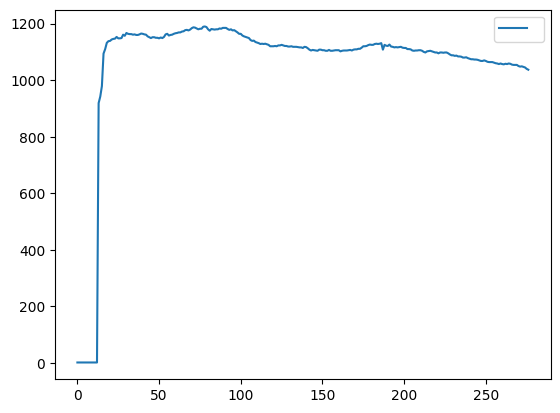

In [54]:
i = 'PriceToTangBVPerShare'
df = pd.read_csv(dir_fp+f'/{i}/{i}.csv')
df.notna().sum(axis=1).plot(legend=True)